In [1]:
import sys, os, jpype
print("python:", sys.version)
print("jpype version:", jpype.__version__)
print("jpype path:", jpype.__file__)   # ← откуда берётся модуль
import tifffile


python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
jpype version: 1.6.0
jpype path: /home/chenmn/miniforge3/envs/pyimagej-310/lib/python3.10/site-packages/jpype/__init__.py


## 1. Stitching ( 75-ii step for protocol)

In [6]:
#Install all necessary packages and JAVA on new enviroment and add paths to JDK, JAVA, MAVEN 
#conda create -n pyimagej-310 -c conda-forge python=3.10 "numpy<2.0" openjdk=17 maven pyimagej=1.6.0
!export CJDK_SKIP=1
!export JGO_JAVA_HOME="$CONDA_PREFIX"
!export JGO_MAVEN="$(which mvn)"


which: no mvn in (/home/chenmn/miniforge3/envs/deconv/bin:/home/chenmn/miniforge3/condabin:/home/chenmn/miniconda3/bin:/usr/local/cuda/bin:/usr/local/nvidia/bin:/opt/app/spack/bin:/opt/app/spack/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/chenmn/.local/bin:/home/chenmn/bin)


In [3]:
import os

os.environ["CJDK_SKIP"] = "1"
os.environ["JGO_JAVA_HOME"] = "/home/chenmn/miniconda/envs/pyimagej-310" # your path to java home
os.environ["JGO_MAVEN"] = "/home/chenmn/miniconda/envs/pyimagej-310/bin/mvn"  # your path to mvn


In [4]:
import os, shutil, subprocess, sys

# 2) Just in case, remove any extra Java environment variables that might interfere with JPype.
os.environ.pop("CLASSPATH", None)
os.environ.pop("JAVA_TOOL_OPTIONS", None)

#3) Path diagnostics
print("CONDA_PREFIX:", os.environ.get("CONDA_PREFIX"))
print("JGO_JAVA_HOME:", os.environ.get("JGO_JAVA_HOME"))
print("JGO_MAVEN:", os.environ.get("JGO_MAVEN"))


CONDA_PREFIX: /home/chenmn/miniforge3/envs/deconv
JGO_JAVA_HOME: /home/chenmn/miniconda/envs/pyimagej-310
JGO_MAVEN: /home/chenmn/miniconda/envs/pyimagej-310/bin/mvn


In [5]:
# Check that all packages are installed and java and maven work
print("java -version:")
print(subprocess.run(["java","-version"], capture_output=True, text=True).stderr)
print("mvn -v:")
print(subprocess.run(["mvn","-v"], capture_output=True, text=True).stdout)


java -version:


FileNotFoundError: [Errno 2] No such file or directory: 'java'

In [5]:
import imagej

In [6]:
#initialize fiji
ij = imagej.init('sc.fiji:fiji', headless=True)

The headless flag of imagej.init is deprecated. Use the mode argument instead.
[ERROR] Cannot create plugin: org.scijava.plugins.scripting.javascript.JavaScriptScriptLanguage


In [9]:
# Add your own params in config

cfg = {
    "type": "Grid: column-by-column",
    "order": "Down & Right",
    "grid_size_x": 7,
    "grid_size_y": 8,
    "tile_overlap": 10.0,
    "first_file_index_i": 1,
    "directory": "../labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/ref_merged/",
    "file_names": "tile_{i}.tif",
    "output_textfile_name": "TileConfiguration.txt",
    "fusion_method": "Linear Blending",
    "regression_threshold": 0.30,
    "max/avg_displacement_threshold": 2.50,
    "absolute_displacement_threshold": 3.50,
    "compute_overlap": True,
    "subpixel_accuracy": True,
    "computation_parameters": "Save computation time (but use more RAM)",
    "image_output": "Fuse and display"
}

In [11]:
# Add directories with files needed to stitch
in_dirs = {
            "ref_merged": "../labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/ref_merged/",
           "Gfap" : "../labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/protein/Gfap/",
           "PI" : "../labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/protein/PI/",
           "plaque": "../labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/protein/plaque/",
           "tau": "../labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/protein/tau/",
          }

In [10]:
#in_dirs = {"ref_merged":"/data/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/ref_merged/"}

In [13]:
out_dir = "../sample-dataset-output-mariia/tissue-2D/images/fused"

In [14]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
out_dirs ={}
for name, d in in_dirs.items():
    out_path = os.path.join(out_dir, f"{name}.tif")
    out_dirs[name] =out_path

In [15]:
out_dirs

{'ref_merged': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif',
 'Gfap': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/Gfap.tif',
 'PI': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif',
 'plaque': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/plaque.tif',
 'tau': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/tau.tif'}

In [16]:
#  Run Stitching (75-ii step for protocol)
for name, d in in_dirs.items():
    out_path = os.path.join(out_dir, f"{name}.tif")
    out_dirs[name] =out_path
    macro = f"""
    run("Grid/Collection stitching", 
    "type=[{cfg['type']}] order=[{cfg['order']}] grid_size_x={cfg['grid_size_x']} grid_size_y={cfg['grid_size_y']} \
    tile_overlap={cfg['tile_overlap']} first_file_index_i={cfg['first_file_index_i']} \
    directory={d} file_names={cfg['file_names']} output_textfile_name={cfg['output_textfile_name']} \
    fusion_method=[{cfg['fusion_method']}] regression_threshold={cfg['regression_threshold']} \
    max/avg_displacement_threshold={cfg['max/avg_displacement_threshold']} \
    absolute_displacement_threshold={cfg['absolute_displacement_threshold']} compute_overlap subpixel_accuracy \
    computation_parameters=[{cfg['computation_parameters']}] image_output=[{cfg['image_output']}]");
    saveAs("Tiff", "{out_path}");
    """

    print(f" Stitching: {name}  →  {out_path}")
    res = ij.py.run_macro(macro)
    print("Out path:", out_path)


Operating in headless mode - the original ImageJ will have limited functionality.


 Stitching: ref_merged  →  /home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif
Stitching internal version: 1.2
Loading (0, 0): /home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/ref_merged/tile_1.tif ... 
Reading IFDs
Populating metadata
Checking comment style
Populating OME metadata
3072x3072px, channels=1, timepoints=1 (1264 ms)
Loading (1, 0): /home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/ref_merged/tile_9.tif ... 
Reading IFDs
Populating metadata
Checking comment style
Populating OME metadata
3072x3072px, channels=1, timepoints=1 (432 ms)
Loading (2, 0): /home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/ref_merged/tile_17.tif ... 
Reading IFDs
Populating metadata
Checking comment style
Populating OME metadata
3072x3072px, channels=1, timepoints=1 (309 ms)
Loading (3, 0): /home/chenmn/labdata/translatome/Zenodo/sample-d

KeyboardInterrupt: 

In [17]:
out_dirs

{'ref_merged': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif',
 'Gfap': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/Gfap.tif',
 'PI': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif',
 'plaque': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/plaque.tif',
 'tau': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/tau.tif'}

In [ ]:
## V2 - try to fix 
import time
import traceback


for name, d in in_dirs.items():
    try:
        out_path = os.path.join(out_dir, f"fused_{name}.tif")
        out_dirs[name] = out_path

        # macro: run stitching, save, close all windows, garbage-collect
        macro = f'''
        setBatchMode(true);
        run("Grid/Collection stitching",
         "type=[{cfg['type']}] order=[{cfg['order']}] grid_size_x={cfg['grid_size_x']} grid_size_y={cfg['grid_size_y']} \
        tile_overlap={cfg['tile_overlap']} first_file_index_i={cfg['first_file_index_i']} \
        directory={d} file_names={cfg['file_names']} output_textfile_name={cfg['output_textfile_name']} \
        fusion_method=[{cfg['fusion_method']}] regression_threshold={cfg['regression_threshold']} \
        max/avg_displacement_threshold={cfg['max/avg_displacement_threshold']} \
        absolute_displacement_threshold={cfg['absolute_displacement_threshold']} compute_overlap subpixel_accuracy \
        computation_parameters=[{cfg['computation_parameters']}] image_output=[{cfg['image_output']}]");
        // wait briefly to allow the plugin to finish its internal processes
        wait(500);
        // save image
        saveAs("Tiff", "{out_path}");
        // close all to prevent memory or window buildup
        run("Close All");
        // garbage-collect(clean up memory)
        call("java.lang.System.gc");
        setBatchMode(false);
        '''
        print(f" Stitching: {name}  →  {out_path}")
        res = ij.py.run_macro(macro)

        #Brief pause in Python (for file system operations)
        time.sleep(0.5)

        # Additional check — verify that the file is created and not empty
        if not os.path.exists(out_path):
            raise RuntimeError(f"Output file not created: {out_path}")
        elif os.path.getsize(out_path) < 1024:  # Threshold 1 KB, adjust if necessary
            print(f"Warning: output {out_path} seems too small ({os.path.getsize(out_path)} bytes)")

        print("Out path:", out_path)

    except Exception as e:
        print(f"Error while stitching {name}: {e}")
        traceback.print_exc()
        # continue


Operating in headless mode - the original ImageJ will have limited functionality.


 Stitching: plaque  →  /data/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/fused_plaque.tif
Stitching internal version: 1.2
Out path: /data/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/fused_plaque.tif
 Stitching: tau  →  /data/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/fused_tau.tif


In [17]:
## Create overlay.tif 

In [18]:
## Create overlay.tif 
from pathlib import Path

In [34]:
overlay_tif_path = str(Path("data/fused/") / "overlay2.tif")

In [35]:
out_dirs

{'PI': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif',
 'ref_merged': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif'}

In [36]:
overlay_tif_path

'data/fused/overlay2.tif'

In [37]:
os.listdir('/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/')

['.ipynb_checkpoints',
 'Gfap.tif',
 'PI.tif',
 'PI_labels.tif',
 'goodSpots.tif',
 'plaque.tif',
 'ref_merged.tif',
 'tau.tif']

In [38]:
out_dirs

{'PI': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif',
 'ref_merged': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif'}

In [39]:
out_dirs = {'PI': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif', 'ref_merged': '/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif'}

## 2. Fused DAPI staining and sequencing image ( 75 v-vi protocol steps)

You can skip this step if you want to use only ClusterMap cell segmentation

In [40]:
import pathlib
import os

paths = list(out_dirs.values())   # если out_dirs — dict
basenames = []
open_cmds = []

# --- Build open() commands safely ---
for p in paths:
    p = pathlib.Path(p)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p}")

    basenames.append(p.name)

    abs_path = str(p.resolve()).replace("\\", "/")
    abs_path = abs_path.replace('"', '\\"')

    open_cmds.append(f'open("{abs_path}");')

# --- Build macro lines: open + capture title ---
macro_lines = []
for i, cmd in enumerate(open_cmds):
    macro_lines.append(cmd)
    # Здесь важно удвоить фигурные скобки
    macro_lines.append(f'title{i+1} = getTitle();')

# --- Build merge args: c1=title1 c2=title2 ... ---
merge_parts = []
for i in range(len(basenames)):
    merge_parts.append(f'c{i+1}=\'{{title{i+1}}}\'')

merge_args = " ".join(merge_parts) + " create"

# --- Full macro ---
overlay_path = str(pathlib.Path(overlay_tif_path).resolve()).replace("\\", "/")

macro = "\n".join(macro_lines) + "\n" + (
    f'run("Merge Channels...", "{merge_args}");\n'
    'run("RGB Color");\n'
    'run("8-bit");\n'
    'run("Enhance Contrast...", "saturated=1 normalize");\n'
    f'saveAs("Tiff", "{overlay_path}");\n'
)

print("Macro:\n", macro)

ij.py.run_macro(macro)
ij.py.run_macro("run('Close All');")

print("Saved:", overlay_tif_path)


Macro:
 open("/groups/g8210173/home/share/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif");
title1 = getTitle();
open("/groups/g8210173/home/share/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/ref_merged.tif");
title2 = getTitle();
run("Merge Channels...", "c1='{title1}' c2='{title2}' create");
run("RGB Color");
run("8-bit");
run("Enhance Contrast...", "saturated=1 normalize");
saveAs("Tiff", "/home/chenmn/translatomics_analyse/data/fused/overlay2.tif");

Saved: data/fused/overlay2.tif


# 3. Check stitching images

In [41]:
## View overlaf data file:
import tifffile
import matplotlib.pyplot as plt

In [42]:
overlay_tif_path

'data/fused/overlay2.tif'

Shape: (22586, 19665)
Data type: uint8
Dimensions: 2D


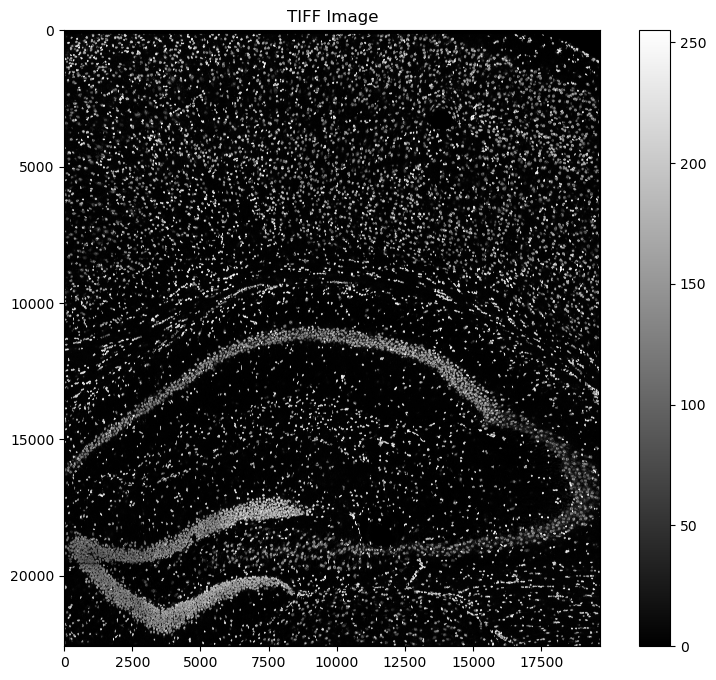

In [43]:

# Read file
image = tifffile.imread(overlay_tif_path)

# Information
print(f"Shape: {image.shape}")
print(f"Data type: {image.dtype}")
print(f"Dimensions: {image.ndim}D")

plt.figure(figsize=(10, 8))
if image.ndim == 2:  # 2D изображение
    plt.imshow(image, cmap='gray')
    plt.colorbar()
elif image.ndim == 3:  # 3D (Z-stack или RGB)
    # Для стека - показываем середину
    middle_slice = image.shape[0] // 2
    plt.imshow(image[middle_slice])
plt.title('TIFF Image')
plt.show()

Shape: (22586, 19665)
Data type: uint8
Dimensions: 2D


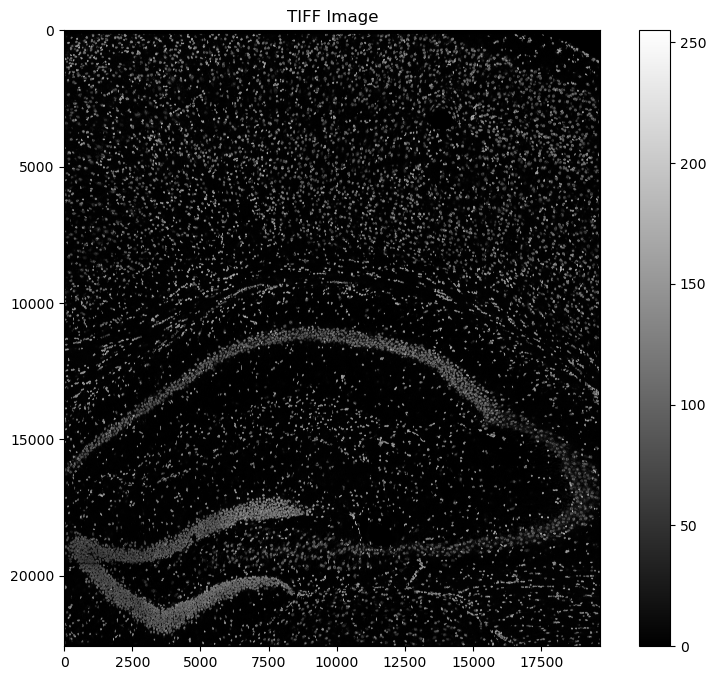

In [47]:

#Read file
image = tifffile.imread(out_dirs['PI'])

# Information
print(f"Shape: {image.shape}")
print(f"Data type: {image.dtype}")
print(f"Dimensions: {image.ndim}D")

plt.figure(figsize=(10, 8))
if image.ndim == 2:  # 2D изображение
    plt.imshow(image, cmap='gray')
    plt.colorbar()
elif image.ndim == 3:  # 3D (Z-stack или RGB)
    # Для стека - показываем середину
    middle_slice = image.shape[0] // 2
    plt.imshow(image[middle_slice])
plt.title('TIFF Image')
plt.show()

Shape: (22581, 19646)
Data type: uint8
Dimensions: 2D


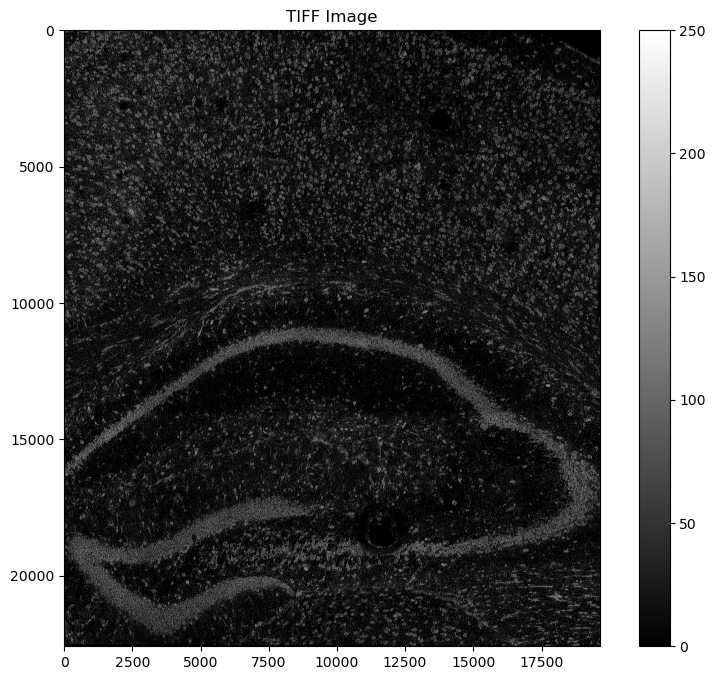

In [50]:

# Read file
image = tifffile.imread(out_dirs['ref_merged'])

# Information
print(f"Shape: {image.shape}")
print(f"Data type: {image.dtype}")
print(f"Dimensions: {image.ndim}D")

plt.figure(figsize=(10, 8))
if image.ndim == 2:  # 2D изображение
    plt.imshow(image, cmap='gray')
    plt.colorbar()
elif image.ndim == 3:  # 3D (Z-stack или RGB)
    # Для стека - показываем середину
    middle_slice = image.shape[0] // 2
    plt.imshow(image[middle_slice])
plt.title('TIFF Image')
plt.show()

In [51]:
out_dirs['PI']

'/home/chenmn/labdata/translatome/Zenodo/sample-dataset-output-mariia/tissue-2D/images/fused/PI.tif'